# Expansion project near Cinema Guzzo

## Business Problem

Cinema Guzzo Mega-Plex Sphèretech 14 in Ville Saint-Laurent, Montreal, Canada is looking to expand! In the mall where the cinema is situated, a new empty spot is available for a business. Cinemas are busy places, and choosing the right business close to a cinema could be very lucrative. But how to choose which type of commerce would be best? A café? A restaurant? Which type?

The stakeholders of Cinema Guzzo want a report on what type of commerce works well around other cinemas in the city so that they can start one of the same type in the mall. There would be even more chances of success if it is a commerce type lacking in the current mall.

For example, if most cinemas in Montreal have multiple cafés nearby and the Sphèretech has few or none, then starting a new café would seem like a good choice.

## Setup

Let's start by importing necessary libraries and defining constants.

In [1]:
# Required libraries
import requests
import json
from collections import namedtuple
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
# Credentials to use the Foursquare API. Loaded from file to avoid having them in clear text here.
with open('credentials.json', 'r') as f:
    foursquare_credentials = json.load(f)

In [3]:
# Constants
FOURSQUARE_VERSION = '20190602'                        # used in Foursquare API calls
MONTREAL_SW = '45.411207032366484,-73.95802478609393'  # Montreal southwest corner lat/long
MONTREAL_NE = '45.70502301979655,-73.47523796592417'   # Montreal northeast corner lat/long
VERBOSE = False                                        # Used in Foursquare API calls to have more output

## Foursquare API

To make the code more concise and clear, all Foursquare API calls have been wrapped by the functions below.

In [4]:
# We'll make quite a few calls to the Foursquare API.
# It is worth it to have a base function to format the URL and interpret the JSON response.

def foursquare_call(url, params):
    """Perform call to Foursquare API
    
    The credentials and version parameters are automatically added to the call.
    Raises an exception if the return code is not 200.
    
    Global constants used:
    foursquare_credentials -- dict of Foursquare credentials, added to call parameters
    FOURSQUARE_VERSION     -- version string added to parameters
    VERBOSE                -- verbosity value (boolean)
    
    Keyword arguments:
    url     -- URL of the call, without parameters, up to but excluding '?'
    params  -- dict of parameters
    
    Returns: the JSON response part, excluding metadata
    """
    params['client_id'] = foursquare_credentials['client_id']
    params['client_secret'] = foursquare_credentials['client_secret']
    params['v'] = FOURSQUARE_VERSION
    results = requests.get(url, params=params)
    if VERBOSE:
        print('GET {}'.format(results.url))
    results_json = results.json()
    code = results_json['meta']['code']
    if code != 200:
        raise Exception("Request '{}' failed with code {}\n{}".format(results.url, code, results_json))
    return results_json['response']

In [5]:
def foursquare_categories():
    """Get venue categories
    
    Returns a hierarchical list (as JSON) of categories applied to venues.
    See https://developer.foursquare.com/docs/api/venues/categories
    
    Returns: the JSON response part, excluding metadata
    """
    url = 'https://api.foursquare.com/v2/venues/categories'
    response = foursquare_call(url, {})
    return response['categories']

In [6]:
def foursquare_search_browse(sw, ne, query=None, categoryId=None, limit=50):
    """Search for venues
    
    Returns a list (as JSON) of venues within a given area.
    See https://developer.foursquare.com/docs/api/venues/search
    
    Keyword arguments:
    sw         -- southwest corner of the bounding box to search
    ne         -- northeast corner of the bounding box to search
    query      -- an optional search term to be applied against venue names
    categoryId -- an optional comma separated list of categories (as a string) to limit results to
    limit      -- maximum number of venues to return (max: 50)
    
    Returns: the venues, in a pandas dataframe
    """
    url = 'https://api.foursquare.com/v2/venues/search'
    params = {'intent': 'browse', 'sw': sw, 'ne':ne, 'limit':limit}
    if query is not None:
        params['query'] = query
    if categoryId is not None:
        params['categoryId'] = categoryId
    response = foursquare_call(url, params)
    return json_normalize(response['venues'])

In [7]:
def foursquare_explore_next_venues(venue, ll, radius=600, limit=50):
    """Get venues people go to after visiting the specified venue.
    
    Returns a list (as JSON) of recommended venues near the specified venue.
    Results may include the venue itself.
    See https://developer.foursquare.com/docs/api/venues/explore
    
    Keyword arguments:
    venue      -- id of the venue around which to search
    ll         -- 'latitude,longitude' string of the venue (assumed already available from another call)
    radius     -- search radius around the venue
    limit      -- maximum number of venues to return (max: 50)
    
    Returns: the JSON response part, excluding metadata and warning messages
    """
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = {'ll': ll, 'radius': radius, 'section': 'nextVenues', 'lastVenue': venue, 'limit':limit}
    response = foursquare_call(url, params)
    return response['groups'][0]['items']

### Data structures related to venue categories

Foursquare uses a category hierarchy, returned as a JSON with multiple levels sub-categories. Since we'll manipulate categories quite a lot, it will be useful to be able to do the following:
- Map a category id to its name
- Map a category id to its level in the hierarchy
- Move from a category to its parent category in the hierarchy
- Map a category name back to a category id

In [8]:
# Get the category hierarchy from Foursquare
categories_json = foursquare_categories()

In [9]:
# Create a data structure with necessary information on a category
Category = namedtuple('Category', ['id', 'name', 'level', 'parent', 'children'])

categories = {}          # Maps an id string to a Category namedtuple
categories_by_name = {}  # Maps a category name back to a category id

# Because of the hierarchical nature of the JSON, we'll use recursion to explore each sub-node of a node.
def add_category_from_json(entry, parent='', level=0):
    """Fill category dictionary recursively from the given JSON dictionary of a node.
    
    Keyword arguments:
    entry   -- JSON dictionary of a node (and its sub-nodes)
    parent  -- category id of the parent node, or '' for top-level nodes
    level   -- tree level, 0 for top-level nodes
    """
    # Create the category tuple with all its information except children
    new_category = Category(entry['id'], entry['name'], level, parent, [])
    
    # Add it to the id-to-category dictionary
    categories[new_category.id] = new_category
    
    # Scan all child nodes recursively
    for child in entry['categories']:
        # Add the child category id to the list of children
        new_category.children.append(child['id'])
        # Recursively add this new category
        add_category_from_json(entry=child, parent=new_category.id, level=level+1)
        
# categories_json constains a list of top-level nodes.
# Call the function above to generate the dictionary recursively.
for entry in categories_json:
    add_category_from_json(entry)
    
# Generate the reverse-lookup dictionary.
for category in categories.values():
    categories_by_name[category.name] = category.id

#### Demo

Let's demonstrate what we can now do with the dictionaries.

In [10]:
categories_by_name['Indian Restaurant']

'4bf58dd8d48988d10f941735'

In [11]:
indian_restaurant = categories[categories_by_name['Indian Restaurant']]
print("'{}': {}".format(indian_restaurant.id, indian_restaurant.name))

'4bf58dd8d48988d10f941735': Indian Restaurant


In [12]:
print('{}->{}->{}'.format(categories[indian_restaurant.parent].name, indian_restaurant.name, categories[indian_restaurant.children[0]].name))

Food->Indian Restaurant->Andhra Restaurant


## Acquire data

### Get the list of cinemas

Let's start by finding the list of cinemas in Montreal.

In [13]:
cinemas_df = foursquare_search_browse(MONTREAL_SW, MONTREAL_NE, categoryId=categories_by_name['Movie Theater'])
cinemas_df.head()

,categories,events.count,events.summary,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",17.0,17 movies,False,4ae367bbf964a5209d9421e3,977 rue Sainte-Catherine Ouest,CA,Montréal,Canada,coin Metcalfe,[977 rue Sainte-Catherine Ouest (coin Metcalfe...,"[{'label': 'display', 'lat': 45.50096571439071...",45.500966,-73.572091,NaN,H3B 4W3,QC,Cinéma Banque Scotia,v-1559792688,NaN
1,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",29.0,29 movies,False,4ad4c06ef964a52008fb20e3,2313 Sainte-Catherine St. West,CA,Montréal,Canada,Coin Atwater,[2313 Sainte-Catherine St. West (Coin Atwater)...,"[{'label': 'display', 'lat': 45.48982006734651...",45.489820,-73.585147,NaN,H3H 1N2,QC,Cineplex Odeon Forum Cinemas,v-1559792688,NaN
2,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",23.0,23 movies,False,4ad4c06ef964a52009fb20e3,2800 rue du Cosmodôme,CA,Laval,Canada,NaN,"[2800 rue du Cosmodôme, Laval QC H7T 2X1, Canada]","[{'label': 'display', 'lat': 45.56385224537918...",45.563852,-73.741913,NaN,H7T 2X1,QC,Cinéma Colossus Laval,v-1559792688,NaN
3,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",NaN,NaN,False,4ad4c06ef964a520ebfa20e3,"3575, avenue du Parc",CA,Montréal,Canada,Coin rue Prince-Arthur Ouest,"[3575, avenue du Parc (Coin rue Prince-Arthur ...","[{'label': 'display', 'lat': 45.51029205519801...",45.510292,-73.575193,NaN,H2X 3P9,QC,Cinéma du Parc,v-1559792688,77386567
4,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",28.0,28 movies,False,4b2522b4f964a520b56c24e3,350 rue Emery,CA,Montréal,Canada,entre St-Denis & Sanguinet,"[350 rue Emery (entre St-Denis & Sanguinet), M...","[{'label': 'display', 'lat': 45.51443190862526...",45.514432,-73.563810,NaN,H2X 1J1,QC,Cinéma Cineplex Odeon Quartier Latin,v-1559792688,NaN


Let's clean this up and keep only the relevant data.

In [14]:
cinemas_df = cinemas_df[['id', 'name', 'location.lat', 'location.lng']]
cinemas_df.columns = ['id', 'name', 'lat', 'lng']
cinemas_df.head()

,id,name,lat,lng
0,4ae367bbf964a5209d9421e3,Cinéma Banque Scotia,45.500966,-73.572091
1,4ad4c06ef964a52008fb20e3,Cineplex Odeon Forum Cinemas,45.489820,-73.585147
2,4ad4c06ef964a52009fb20e3,Cinéma Colossus Laval,45.563852,-73.741913
3,4ad4c06ef964a520ebfa20e3,Cinéma du Parc,45.510292,-73.575193
4,4b2522b4f964a520b56c24e3,Cinéma Cineplex Odeon Quartier Latin,45.514432,-73.563810


### Get venues people go to after the cinema

For each cinema found above, get the popular "next" venues in a radius of 600 meters around it. Build a list with all the JSON responses for later analysis.

In [15]:
near_cinemas = []
for index, cinema in cinemas_df.iterrows():
    # Build 'latitude,longitude' string from the dataframe info above
    ll = '{},{}'.format(cinema['lat'], cinema['lng'])
    # Perform the Foursquare call and append the JSON response to the list
    near_cinemas.append( foursquare_explore_next_venues(cinema['id'], ll) )
    print('*', end='')
print('\nData acquisition complete.')

**************************
Data acquisition complete.


#### Demo

As a sanity check, let's print each cinema name along with the name of its first "next" venue.

In [36]:
# The JSON for the first venue near the first cinema looks like this.
near_cinemas[0][0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4b59d9f0f964a520e79b28e3',
  'name': 'Dominion Square Tavern',
  'location': {'address': '1243 rue Metcalfe',
   'crossStreet': 'entre Ste-Catherine & René-Lévesque',
   'lat': 45.50040540450307,
   'lng': -73.57163553893498,
   'labeledLatLngs': [{'label': 'display',
     'lat': 45.50040540450307,
     'lng': -73.57163553893498}],
   'distance': 71,
   'postalCode': 'H3B 2V5',
   'cc': 'CA',
   'city': 'Montréal',
   'state': 'QC',
   'country': 'Canada',
   'formattedAddress': ['1243 rue Metcalfe (entre Ste-Catherine & René-Lévesque)',
    'Montréal QC H3B 2V5',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d155941735',
    'name': 'Gastropub',
    'pluralName': 'Gastropubs',
    'shortName': 'Gastropub',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_',
     'suffix': '.png'},
    'pr

In [17]:
demo = []
for index, cinema in cinemas_df.iterrows():
    demo.append([cinema['name'], near_cinemas[index][0]['venue']['name']])
pd.DataFrame(demo, columns=['Cinema Name', 'Nearby venue'])


,Cinema Name,Nearby venue
0,Cinéma Banque Scotia,Dominion Square Tavern
1,Cineplex Odeon Forum Cinemas,Café Pacefika
2,Cinéma Colossus Laval,Première Moisson
3,Cinéma du Parc,Salon de thé CHAI tea lounge
4,Cinéma Cineplex Odeon Quartier Latin,Camellia Sinensis
5,Méga-Plex Guzzo Marché Central 18,MEC Montréal
6,Cinéma Colisée Kirkland,Madisons Restaurant & Bar
7,Cinéma J.A. De Sève,La Panthère Verte
8,Cinéma Starcité Montréal,Planétarium Rio Tinto Alcan
9,Méga-Plex Guzzo Taschereau 18,Winners


## Data wrangling

### Clean up nearby venues

Turn the JSON for the "near venues" of each cinema into dataframes. Keep only the venue name and category.

In [18]:
near_cinema_df_list = []
for cinema_idx, near_cinema in enumerate(near_cinemas):
    cinema_id = cinemas_df.iloc[cinema_idx]['id']
    cinema_name = cinemas_df.iloc[cinema_idx]['name']
    places = []
    for place in near_cinema:
        venue = place['venue']
        if venue['id'] != cinema_id: # exclude the cinema itself in the list of places
            places.append([venue['name'], venue['categories'][0]['id']])
    places_df = pd.DataFrame(places, columns = ['name', 'category'])
    near_cinema_df_list.append( (cinema_name, places_df) )

In [19]:
# Result example for the first cinema
print(near_cinema_df_list[0][0])
near_cinema_df_list[0][1].head()

Cinéma Banque Scotia


,name,category
0,Dominion Square Tavern,4bf58dd8d48988d155941735
1,Ferreira Café,4def73e84765ae376e57713a
2,Club Sportif MAA,4bf58dd8d48988d176941735
3,NStyle Beauty Lounge,4bf58dd8d48988d1ed941735
4,Indigo,4bf58dd8d48988d114951735


### Add more category information

For each venue, add its category and the category level in the hierarchy, as new columns in the dataframes.

In [20]:
for cinema_name, near_cinema_df in near_cinema_df_list:
    near_cinema_df['category_name']  = near_cinema_df['category'].apply(lambda id: categories[id].name )
    near_cinema_df['category_level'] = near_cinema_df['category'].apply(lambda id: categories[id].level)

# Results for the first cinema
near_cinema_df_list[0][1].head()

,name,category,category_name,category_level
0,Dominion Square Tavern,4bf58dd8d48988d155941735,Gastropub,1
1,Ferreira Café,4def73e84765ae376e57713a,Portuguese Restaurant,1
2,Club Sportif MAA,4bf58dd8d48988d176941735,Gym,3
3,NStyle Beauty Lounge,4bf58dd8d48988d1ed941735,Spa,1
4,Indigo,4bf58dd8d48988d114951735,Bookstore,1


### Popular categories

Group venue categories from around all cinemas into a single list, and check which categories are more frequent.

In [21]:
all_categories = []
for cinema_name, near_cinema_df in near_cinema_df_list:
    if 'Spheretech' not in cinema_name: # exclude the target cinema from the stats
        all_categories.extend(near_cinema_df['category_name'].tolist())

pd.Series(all_categories).value_counts()

Café                               39
Coffee Shop                        33
Italian Restaurant                 26
Breakfast Spot                     22
Pharmacy                           21
Pizza Place                        20
Fast Food Restaurant               20
Restaurant                         19
Bar                                18
Sandwich Place                     17
French Restaurant                  16
Grocery Store                      15
Gym                                15
Furniture / Home Store             13
Sushi Restaurant                   13
Bakery                             12
Dessert Shop                       12
Boutique                           11
Supermarket                        11
Gym / Fitness Center               10
Clothing Store                     10
Tea Room                            9
Gastropub                           9
Brewery                             9
Pub                                 9
Sporting Goods Shop                 9
Vietnamese R

One can see above that the categories are very fragmented. For example, there are 13 sushi restaurants, 9 vietnamese restaurants, 8 korean restaurants... Because the categories are so specific, the weight of the underlying category is diluted.

Look at the full category hierarchy here: <https://developer.foursquare.com/docs/resources/categories>.

Instead of using the lowest-level category in the hierarchy, we will go up and use level 1 of the hierarchy for most categories, except for the _Food & Drink Shop_ category, where we will go to level 2, since level 1 is too broad.

In [22]:
# Add function that iteratively go up in the category hierarchy.
def find_top_level_category(id):
    """Return the category tuple of the level 1 (or 2) category corresponding to the given category id."""
    cur_category = categories[id]
    while cur_category.level > 1:
        if categories[cur_category.parent].name == 'Food & Drink Shop':
            break
        cur_category = categories[cur_category.parent]
    return cur_category

# Add a column to the dataframes with the 'top-level' category
for cinema_name, near_cinema_df in near_cinema_df_list:
    near_cinema_df['top_level_category'] = near_cinema_df['category'].apply(lambda id: find_top_level_category(id).name)
    
# Results for the first cinema
near_cinema_df_list[0][1].head()

,name,category,category_name,category_level,top_level_category
0,Dominion Square Tavern,4bf58dd8d48988d155941735,Gastropub,1,Gastropub
1,Ferreira Café,4def73e84765ae376e57713a,Portuguese Restaurant,1,Portuguese Restaurant
2,Club Sportif MAA,4bf58dd8d48988d176941735,Gym,3,Athletics & Sports
3,NStyle Beauty Lounge,4bf58dd8d48988d1ed941735,Spa,1,Spa
4,Indigo,4bf58dd8d48988d114951735,Bookstore,1,Bookstore


Try grouping the top-level categories instead of the lower-level categories.

In [23]:
all_categories = []
for cinema_name, near_cinema_df in near_cinema_df_list:
    if 'Spheretech' not in cinema_name: # exclude the target cinema from the stats
        all_categories.extend(near_cinema_df['top_level_category'].tolist())

histogram = pd.Series(all_categories).value_counts()
histogram

Bar                                55
Asian Restaurant                   54
Café                               39
Athletics & Sports                 38
Coffee Shop                        33
Clothing Store                     32
Italian Restaurant                 26
Dessert Shop                       22
Breakfast Spot                     22
Pharmacy                           21
Fast Food Restaurant               20
Pizza Place                        20
Restaurant                         19
Sandwich Place                     17
French Restaurant                  16
Grocery Store                      15
Museum                             13
Furniture / Home Store             13
Performing Arts Venue              12
Bakery                             12
Supermarket                        11
Middle Eastern Restaurant           9
Burger Joint                        9
Tea Room                            9
Gastropub                           9
Sporting Goods Shop                 9
Brewery     

Ah, much better! As you can see, _Asian Restaurants_ are now in second position because we consolidated the sub-categories.

Let's keep the 20 most popular categories.

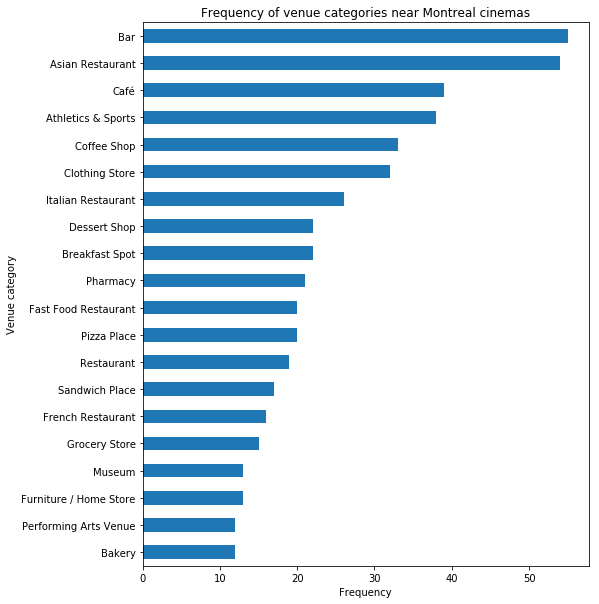

In [24]:
histogram = histogram.head(20)
histogram.plot.barh(figsize=(8, 10))

plt.title('Frequency of venue categories near Montreal cinemas')
plt.xlabel('Frequency')
plt.ylabel('Venue category')

plt.gca().invert_yaxis()
plt.show()

In [25]:
popular_categories = histogram.index.tolist()
popular_categories

['Bar',
 'Asian Restaurant',
 'Café',
 'Athletics & Sports',
 'Coffee Shop',
 'Clothing Store',
 'Italian Restaurant',
 'Dessert Shop',
 'Breakfast Spot',
 'Pharmacy',
 'Fast Food Restaurant',
 'Pizza Place',
 'Restaurant',
 'Sandwich Place',
 'French Restaurant',
 'Grocery Store',
 'Museum',
 'Furniture / Home Store',
 'Performing Arts Venue',
 'Bakery']

## Creating the average cinema

We now have the list of most popular venues after going to the cinemas. How many of each venue is around the average cinema?

Let's turn the data around by grouping by top-level category.

In [26]:
print(near_cinema_df_list[0][0])
near_cinema_df_list[0][1]['top_level_category'].value_counts()

Cinéma Banque Scotia


Clothing Store                   6
Café                             5
Athletics & Sports               4
Pizza Place                      3
Gastropub                        3
Coffee Shop                      2
Bar                              2
Dessert Shop                     2
General Entertainment            1
Deli / Bodega                    1
Vegetarian / Vegan Restaurant    1
Spa                              1
Fast Food Restaurant             1
Portuguese Restaurant            1
Diner                            1
Steakhouse                       1
Shopping Mall                    1
Museum                           1
Bookstore                        1
Scenic Lookout                   1
Burger Joint                     1
Restaurant                       1
Mexican Restaurant               1
Sporting Goods Shop              1
Sandwich Place                   1
Building                         1
Chocolate Shop                   1
Spiritual Center                 1
Park                

Create a new dataframe with all cinemas and their categories.

In [27]:
cinema_trends_df = pd.DataFrame()
for cinema_name, near_cinema_df in near_cinema_df_list:
    histogram = near_cinema_df['top_level_category'].value_counts()
    cinema_trends_df = cinema_trends_df.append(histogram, ignore_index=True)

cinema_trends_df.head()

,Athletics & Sports,Bar,Bookstore,Building,Burger Joint,Café,Chocolate Shop,Clothing Store,Coffee Shop,Deli / Bodega,...,IT Services,Pet Store,Video Store,Health Food Store,Kitchen Supply Store,Theme Park,Caribbean Restaurant,Donut Shop,Playground,Sri Lankan Restaurant
0,4.0,2.0,1.0,1.0,1.0,5.0,1.0,6.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,1.0,1.0,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,7.0,NaN,NaN,NaN,5.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,9.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `append` DataFrame method merged all the columns together, adding NaN in case one row didn't have that column.

Let's clean the data a little:
- Keep only popular categories.
- Replace NaNs with 0.0.
- Set a nicer index.

In [28]:
cinema_trends_df = cinema_trends_df[popular_categories]
cinema_trends_df.fillna(0, inplace=True)
cinema_trends_df.set_index(cinemas_df['name'], inplace=True)
cinema_trends_df.index.names = ['Cinema']
cinema_trends_df.head()

,Bar,Asian Restaurant,Café,Athletics & Sports,Coffee Shop,Clothing Store,Italian Restaurant,Dessert Shop,Breakfast Spot,Pharmacy,Fast Food Restaurant,Pizza Place,Restaurant,Sandwich Place,French Restaurant,Grocery Store,Museum,Furniture / Home Store,Performing Arts Venue,Bakery
Cinema,,,,,,,,,,,,,,,,,,,,
Cinéma Banque Scotia,2.0,0.0,5.0,4.0,2.0,6.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Cineplex Odeon Forum Cinemas,0.0,8.0,1.0,2.0,5.0,2.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0
Cinéma Colossus Laval,0.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,1.0
Cinéma du Parc,7.0,4.0,5.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
Cinéma Cineplex Odeon Quartier Latin,9.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0


Single out Cinema Guzzo Mega-Plex Sphèretech 14, and average the other cinemas.

In [29]:
target_cinema = 'Méga-Plex Guzzo Spheretech 14'
spheretech = cinema_trends_df.loc[target_cinema]
other_cinemas = cinema_trends_df.drop(target_cinema)

In [30]:
pd.set_option('precision',1)
other_cinemas.iloc[:, :10].describe()

,Bar,Asian Restaurant,Café,Athletics & Sports,Coffee Shop,Clothing Store,Italian Restaurant,Dessert Shop,Breakfast Spot,Pharmacy
count,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
mean,2.2,2.2,1.6,1.5,1.3,1.3,1.0,0.9,0.9,0.8
std,3.1,2.2,1.8,1.7,1.2,1.7,1.3,1.0,1.1,0.9
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
75%,5.0,4.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
max,9.0,8.0,5.0,7.0,5.0,6.0,4.0,3.0,3.0,3.0


In [31]:
other_cinemas.iloc[:, 10:].describe()

,Fast Food Restaurant,Pizza Place,Restaurant,Sandwich Place,French Restaurant,Grocery Store,Museum,Furniture / Home Store,Performing Arts Venue,Bakery
count,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
mean,0.8,0.8,0.8,0.7,0.6,0.6,0.5,0.5,0.5,0.5
std,0.8,0.9,1.1,0.6,1.2,0.8,1.0,1.1,1.2,0.6
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
max,3.0,3.0,4.0,2.0,4.0,3.0,4.0,5.0,5.0,2.0


## Comparison and Visualization

Compare Sphèretech to the other cinemas.



In [32]:
comparison_df = pd.DataFrame([spheretech, other_cinemas.mean()])
comparison_df.index = ['Spheretech', 'Average cinema']
comparison_df

,Bar,Asian Restaurant,Café,Athletics & Sports,Coffee Shop,Clothing Store,Italian Restaurant,Dessert Shop,Breakfast Spot,Pharmacy,Fast Food Restaurant,Pizza Place,Restaurant,Sandwich Place,French Restaurant,Grocery Store,Museum,Furniture / Home Store,Performing Arts Venue,Bakery
Spheretech,1.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Average cinema,2.2,2.2,1.6,1.5,1.3,1.3,1.0,0.9,0.9,0.8,0.8,0.8,0.8,0.7,0.6,0.6,0.5,0.5,0.5,0.5


Let's show only the categories where Spheretech has fewer venues than the average cinema.

In [33]:
lacking_categories = comparison_df.iloc[0][comparison_df.iloc[0] < comparison_df.iloc[1]].index
comparison_df[lacking_categories]

,Bar,Café,Athletics & Sports,Coffee Shop,Italian Restaurant,Pharmacy,Pizza Place,French Restaurant,Grocery Store,Museum,Furniture / Home Store,Performing Arts Venue,Bakery
Spheretech,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Average cinema,2.2,1.6,1.5,1.3,1.0,0.8,0.8,0.6,0.6,0.5,0.5,0.5,0.5


Let's visualize the comparison using a boxplot.

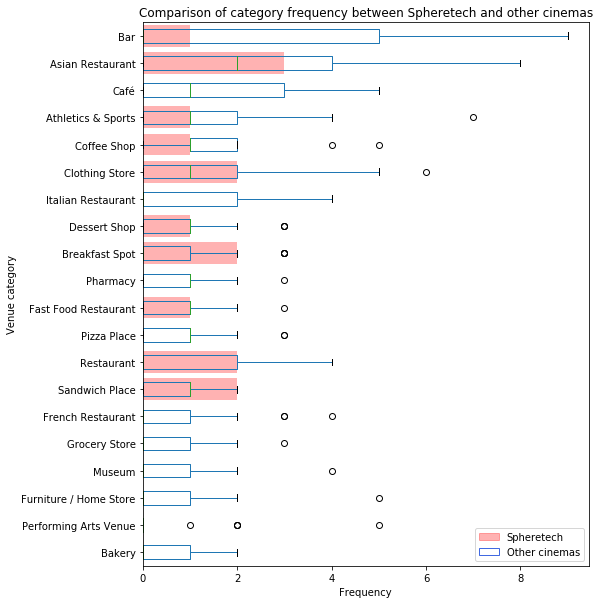

In [34]:
# Plot all the cinemas (except Spheretech) as a boxplot
ax = other_cinemas.boxplot(figsize=(8, 10), grid=False, vert=False)

plt.title('Comparison of category frequency between Spheretech and other cinemas')
plt.xlabel('Frequency')
plt.ylabel('Venue category')

# Add a transparent red bar chart on top of the boxplot to represent Spheretech
ax.barh(range(1, len(spheretech)+1), spheretech.tolist(), color='red', alpha=0.3)

# Add a legend
red_patch = mpatches.Patch(color='red', alpha=0.3, label='Spheretech')
blue_patch = mpatches.Patch(fill=False, color='royalblue', label='Other cinemas')
plt.legend(handles=[red_patch, blue_patch])

plt.gca().invert_yaxis()
plt.show()

## Conclusion

Looking at the results above, we recommend the following venue categories:
- Café
- Italian Restaurant
- A second bar